In [1]:
#import pandas as pd
#from sodapy import Socrata

#client = Socrata("www.datos.gov.co", None)

#df_2020_2 = pd.DataFrame(client.get("rnvb-vnyh", limit=504872, offset=0))

#df_2020_1 = pd.DataFrame(client.get("a8xr-en99", limit=15435, offset=0))

In [2]:
import polars as pl
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [3]:
# define functions
def lower_names(df):
    l_names = {col: col.lower() for col in df.columns}
    return df.rename(l_names)

def plot_null_vals(df):
    null_bool = df.select([pl.col(col).is_null() for col in df.columns])
    
    null_array = null_bool.to_numpy().astype(int).T
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.imshow(null_array, aspect='auto', cmap='viridis', interpolation='none')
    
    ax.set_yticks(range(len(df.columns)))
    ax.set_yticklabels(df.columns)
    ax.set_xticks([])
    plt.title('Valores nulos por columna')
    
    return plt.show()

def data_type(df):
    df_type = pl.DataFrame(
        {
            "col_name": df.columns,
            "var_type": [df_h[col].dtype for col in df.columns]
        }
    )

    return df_type

In [4]:
# load data
df_h = pl.read_csv("Resultados__nicos_Saber_11_20250303.tsv", separator="\t", decimal_comma = True)

df_h.head()

PERIODO,ESTU_TIPODOCUMENTO,ESTU_CONSECUTIVO,COLE_AREA_UBICACION,COLE_BILINGUE,COLE_CALENDARIO,COLE_CARACTER,COLE_COD_DANE_ESTABLECIMIENTO,COLE_COD_DANE_SEDE,COLE_COD_DEPTO_UBICACION,COLE_COD_MCPIO_UBICACION,COLE_CODIGO_ICFES,COLE_DEPTO_UBICACION,COLE_GENERO,COLE_JORNADA,COLE_MCPIO_UBICACION,COLE_NATURALEZA,COLE_NOMBRE_ESTABLECIMIENTO,COLE_NOMBRE_SEDE,COLE_SEDE_PRINCIPAL,ESTU_COD_DEPTO_PRESENTACION,ESTU_COD_MCPIO_PRESENTACION,ESTU_COD_RESIDE_DEPTO,ESTU_COD_RESIDE_MCPIO,ESTU_DEPTO_PRESENTACION,ESTU_DEPTO_RESIDE,ESTU_ESTADOINVESTIGACION,ESTU_ESTUDIANTE,ESTU_FECHANACIMIENTO,ESTU_GENERO,ESTU_MCPIO_PRESENTACION,ESTU_MCPIO_RESIDE,ESTU_NACIONALIDAD,ESTU_PAIS_RESIDE,ESTU_PRIVADO_LIBERTAD,FAMI_CUARTOSHOGAR,FAMI_EDUCACIONMADRE,FAMI_EDUCACIONPADRE,FAMI_ESTRATOVIVIENDA,FAMI_PERSONASHOGAR,FAMI_TIENEAUTOMOVIL,FAMI_TIENECOMPUTADOR,FAMI_TIENEINTERNET,FAMI_TIENELAVADORA,DESEMP_INGLES,PUNT_INGLES,PUNT_MATEMATICAS,PUNT_SOCIALES_CIUDADANAS,PUNT_C_NATURALES,PUNT_LECTURA_CRITICA,PUNT_GLOBAL
i64,str,str,str,str,str,str,i64,i64,i64,i64,i64,str,str,str,str,str,str,str,str,i64,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64
20131,"""CR""","""SB11201310000414""","""URBANO""","""N""","""B""","""ACADÉMICO""",311848000812,311848000812,11,11001,22574,"""BOGOTA""","""FEMENINO""","""COMPLETA""","""BOGOTÁ D.C.""","""NO OFICIAL""","""GIMN FEMENINO""","""GIMN FEMENINO""","""S""",11,11001,11,11001,"""BOGOTÁ""","""BOGOTÁ""","""PUBLICAR""","""ESTUDIANTE""","""08/08/1994""","""F""","""BOGOTÁ D.C.""","""BOGOTÁ D.C.""","""COLOMBIA""","""COLOMBIA""","""N""","""Cuatro""","""Educación profesional completa""","""Educación profesional completa""","""Estrato 6""","""Cuatro""","""Si""","""Si""","""Si""","""Si""","""B+""","""94""","""88""",null,null,null,null
20194,"""TI""","""SB11201940464873""","""RURAL""","""N""","""A""","""TÉCNICO/ACADÉMICO""",141016000305,241016000342,41,41016,194878,"""HUILA""","""MIXTO""","""COMPLETA""","""AIPE""","""OFICIAL""","""INSTITUCION EDUCATIVA JESUS MA…","""DINDAL""","""N""",41,41016,41,41016,"""HUILA""","""HUILA""","""PUBLICAR""","""ESTUDIANTE""","""15/02/2003""","""F""","""AIPE""","""AIPE""","""COLOMBIA""","""COLOMBIA""","""N""","""Dos""","""Postgrado""","""Primaria completa""","""Estrato 2""","""1 a 2""","""No""","""Si""","""Si""","""Si""","""B1""","""71""","""66""",70,65,69,339
20194,"""TI""","""SB11201940464873""","""RURAL""","""N""","""A""","""TÉCNICO/ACADÉMICO""",141016000305,241016000342,41,41016,194878,"""HUILA""","""MIXTO""","""COMPLETA""","""AIPE""","""OFICIAL""","""INSTITUCION EDUCATIVA JESUS MA…","""DINDAL""","""N""",41,41016,41,41016,"""HUILA""","""HUILA""","""PUBLICAR""","""ESTUDIANTE""","""15/02/2003""","""F""","""AIPE""","""AIPE""","""COLOMBIA""","""COLOMBIA""","""N""","""Dos""","""Postgrado""","""Primaria completa""","""Estrato 2""","""1 a 2""","""No""","""Si""","""Si""","""Si""","""B1""","""71""","""66""",70,65,69,339
20122,"""TI""","""SB11201220204399""","""URBANO""","""N""","""A""","""TÉCNICO/ACADÉMICO""",163130000718,163130000718,63,63130,13029,"""QUINDIO""","""MIXTO""","""MAÑANA""","""CALARCÁ""","""OFICIAL""","""INSTITUCION EDUCATIVA ANTONIO …","""ANTONIO NARIÑO""","""S""",63,63130,63,63130,"""QUINDIO""","""QUINDIO""","""PUBLICAR""","""ESTUDIANTE""","""20/05/1996""","""F""","""CALARCÁ""","""CALARCÁ""","""COLOMBIA""","""COLOMBIA""","""N""","""Dos""","""Secundaria (Bachillerato) inco…","""No sabe""","""Estrato 1""","""Cuatro""","""No""","""Si""","""Si""","""No""","""A1""","""48""","""45""",null,null,null,null
20132,"""TI""","""SB11201320464198""","""URBANO""","""N""","""A""","""TÉCNICO""",119001000559,119001000559,19,19001,46391,"""CAUCA""","""FEMENINO""","""MAÑANA""","""POPAYÁN""","""OFICIAL""","""CRISTO REY""","""SEDE CRISTO REY""","""S""",19,19001,19,19001,"""CAUCA""","""CAUCA""","""PUBLICAR""","""ESTUDIANTE""","""19/03/1997""","""F""","""POPAYÁN""","""POPAYÁN""","""COLOMBIA""","""COLOMBIA""","""N""","""Cinco""","""Educación profesional completa""","

In [5]:
# clean names
df_h = lower_names(df_h)

df_h.head()

periodo,estu_tipodocumento,estu_consecutivo,cole_area_ubicacion,cole_bilingue,cole_calendario,cole_caracter,cole_cod_dane_establecimiento,cole_cod_dane_sede,cole_cod_depto_ubicacion,cole_cod_mcpio_ubicacion,cole_codigo_icfes,cole_depto_ubicacion,cole_genero,cole_jornada,cole_mcpio_ubicacion,cole_naturaleza,cole_nombre_establecimiento,cole_nombre_sede,cole_sede_principal,estu_cod_depto_presentacion,estu_cod_mcpio_presentacion,estu_cod_reside_depto,estu_cod_reside_mcpio,estu_depto_presentacion,estu_depto_reside,estu_estadoinvestigacion,estu_estudiante,estu_fechanacimiento,estu_genero,estu_mcpio_presentacion,estu_mcpio_reside,estu_nacionalidad,estu_pais_reside,estu_privado_libertad,fami_cuartoshogar,fami_educacionmadre,fami_educacionpadre,fami_estratovivienda,fami_personashogar,fami_tieneautomovil,fami_tienecomputador,fami_tieneinternet,fami_tienelavadora,desemp_ingles,punt_ingles,punt_matematicas,punt_sociales_ciudadanas,punt_c_naturales,punt_lectura_critica,punt_global
i64,str,str,str,str,str,str,i64,i64,i64,i64,i64,str,str,str,str,str,str,str,str,i64,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64
20131,"""CR""","""SB11201310000414""","""URBANO""","""N""","""B""","""ACADÉMICO""",311848000812,311848000812,11,11001,22574,"""BOGOTA""","""FEMENINO""","""COMPLETA""","""BOGOTÁ D.C.""","""NO OFICIAL""","""GIMN FEMENINO""","""GIMN FEMENINO""","""S""",11,11001,11,11001,"""BOGOTÁ""","""BOGOTÁ""","""PUBLICAR""","""ESTUDIANTE""","""08/08/1994""","""F""","""BOGOTÁ D.C.""","""BOGOTÁ D.C.""","""COLOMBIA""","""COLOMBIA""","""N""","""Cuatro""","""Educación profesional completa""","""Educación profesional completa""","""Estrato 6""","""Cuatro""","""Si""","""Si""","""Si""","""Si""","""B+""","""94""","""88""",null,null,null,null
20194,"""TI""","""SB11201940464873""","""RURAL""","""N""","""A""","""TÉCNICO/ACADÉMICO""",141016000305,241016000342,41,41016,194878,"""HUILA""","""MIXTO""","""COMPLETA""","""AIPE""","""OFICIAL""","""INSTITUCION EDUCATIVA JESUS MA…","""DINDAL""","""N""",41,41016,41,41016,"""HUILA""","""HUILA""","""PUBLICAR""","""ESTUDIANTE""","""15/02/2003""","""F""","""AIPE""","""AIPE""","""COLOMBIA""","""COLOMBIA""","""N""","""Dos""","""Postgrado""","""Primaria completa""","""Estrato 2""","""1 a 2""","""No""","""Si""","""Si""","""Si""","""B1""","""71""","""66""",70,65,69,339
20194,"""TI""","""SB11201940464873""","""RURAL""","""N""","""A""","""TÉCNICO/ACADÉMICO""",141016000305,241016000342,41,41016,194878,"""HUILA""","""MIXTO""","""COMPLETA""","""AIPE""","""OFICIAL""","""INSTITUCION EDUCATIVA JESUS MA…","""DINDAL""","""N""",41,41016,41,41016,"""HUILA""","""HUILA""","""PUBLICAR""","""ESTUDIANTE""","""15/02/2003""","""F""","""AIPE""","""AIPE""","""COLOMBIA""","""COLOMBIA""","""N""","""Dos""","""Postgrado""","""Primaria completa""","""Estrato 2""","""1 a 2""","""No""","""Si""","""Si""","""Si""","""B1""","""71""","""66""",70,65,69,339
20122,"""TI""","""SB11201220204399""","""URBANO""","""N""","""A""","""TÉCNICO/ACADÉMICO""",163130000718,163130000718,63,63130,13029,"""QUINDIO""","""MIXTO""","""MAÑANA""","""CALARCÁ""","""OFICIAL""","""INSTITUCION EDUCATIVA ANTONIO …","""ANTONIO NARIÑO""","""S""",63,63130,63,63130,"""QUINDIO""","""QUINDIO""","""PUBLICAR""","""ESTUDIANTE""","""20/05/1996""","""F""","""CALARCÁ""","""CALARCÁ""","""COLOMBIA""","""COLOMBIA""","""N""","""Dos""","""Secundaria (Bachillerato) inco…","""No sabe""","""Estrato 1""","""Cuatro""","""No""","""Si""","""Si""","""No""","""A1""","""48""","""45""",null,null,null,null
20132,"""TI""","""SB11201320464198""","""URBANO""","""N""","""A""","""TÉCNICO""",119001000559,119001000559,19,19001,46391,"""CAUCA""","""FEMENINO""","""MAÑANA""","""POPAYÁN""","""OFICIAL""","""CRISTO REY""","""SEDE CRISTO REY""","""S""",19,19001,19,19001,"""CAUCA""","""CAUCA""","""PUBLICAR""","""ESTUDIANTE""","""19/03/1997""","""F""","""POPAYÁN""","""POPAYÁN""","""COLOMBIA""","""COLOMBIA""","""N""","""Cinco""","""Educación profesional completa""","

In [6]:
df_h.group_by("periodo").len()

periodo,len
i64,u32
20211,15528
20221,20049
20101,41656
20132,548596
20181,32348
…,…
20162,550275
20171,13018
20131,35179


In [7]:
# filter periods
df_h = df_h.filter(df_h["periodo"].is_in([20171, 20172, 20191, 20194]))

df_h.shape

(1670372, 51)

In [8]:
# sample 500.000 records
df_h = df_h.sample(n = 500000, seed = 2025)

In [9]:
#clean data type
df_h = df_h.with_columns(
    pl.col("punt_matematicas").cast(pl.Float64),
    pl.col("punt_ingles").cast(pl.Float64)
)

In [10]:
# print data type
data_type(df_h)

col_name,var_type
str,object
"""periodo""",Int64
"""estu_tipodocumento""",String
"""estu_consecutivo""",String
"""cole_area_ubicacion""",String
"""cole_bilingue""",String
…,…
"""punt_matematicas""",Float64
"""punt_sociales_ciudadanas""",Int64
"""punt_c_naturales""",Int64


In [11]:
cols_punt = [col for col in df_h.columns if col.startswith("punt_")]

df_h.select(cols_punt).describe()

statistic,punt_ingles,punt_matematicas,punt_sociales_ciudadanas,punt_c_naturales,punt_lectura_critica,punt_global
str,f64,f64,f64,f64,f64,f64
"""count""",499988.0,500000.0,500000.0,500000.0,500000.0,500000.0
"""null_count""",12.0,0.0,0.0,0.0,0.0,0.0
"""mean""",49.09884,50.608844,47.75663,49.40955,52.659148,250.154332
"""std""",12.55179,12.11872,12.086802,10.745406,10.375504,51.290681
"""min""",0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",40.0,42.0,38.0,41.0,45.0,211.0
"""50%""",48.0,51.0,47.0,49.0,53.0,247.0
"""75%""",57.0,59.0,57.0,57.0,60.0,286.0
"""max""",100.0,100.0,100.0,100.0,100.0,476.0


In [12]:
# Arbitrary select vars
df_h = df_h.select(["estu_genero", "cole_calendario", "fami_educacionmadre", "fami_educacionpadre",
                    "fami_estratovivienda", "fami_tienecomputador", "cole_area_ubicacion", "fami_tieneinternet", "punt_global"])

In [13]:
# NA values
pl.DataFrame(
    {
        "col_name": df_h.columns,
        "missing_values": [df_h[col].null_count() for col in df_h.columns]
    }
) \
.sort("missing_values", descending = True)

col_name,missing_values
str,i64
"""fami_estratovivienda""",29308
"""fami_tieneinternet""",26468
"""fami_educacionpadre""",25887
"""fami_educacionmadre""",25831
"""fami_tienecomputador""",13156
"""estu_genero""",78
"""cole_calendario""",0
"""cole_area_ubicacion""",0
"""punt_global""",0


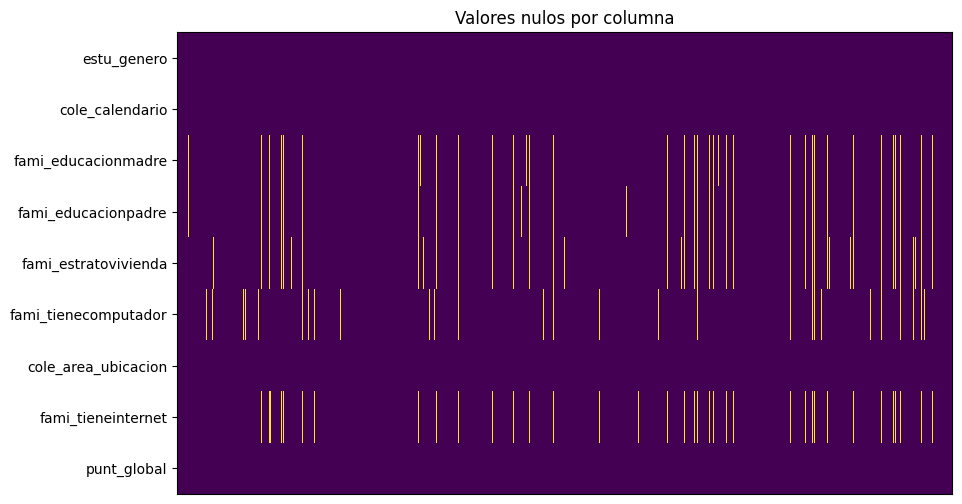

In [14]:
plot_null_vals(df_h)

In [15]:
# delete null values
df_h = df_h.drop_nulls()

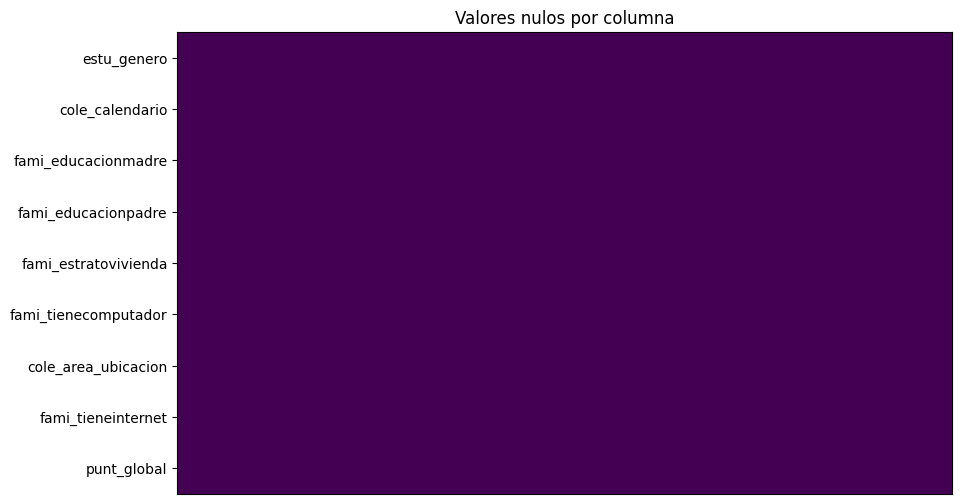

In [16]:
# verfy delete null values
plot_null_vals(df_h)

In [17]:
print("Luego de la selección arbitraria de variables y de la eliminación de datos perdidos, se observa un total de " + str(df_h.shape[0]) +
      " filas y " + str(df_h.shape[1]) + " columnas")

Luego de la selección arbitraria de variables y de la eliminación de datos perdidos, se observa un total de 460977 filas y 9 columnas


In [18]:
# print data type
data_type(df_h)

col_name,var_type
str,object
"""estu_genero""",String
"""cole_calendario""",String
"""fami_educacionmadre""",String
"""fami_educacionpadre""",String
"""fami_estratovivienda""",String
"""fami_tienecomputador""",String
"""cole_area_ubicacion""",String
"""fami_tieneinternet""",String
"""punt_global""",Int64


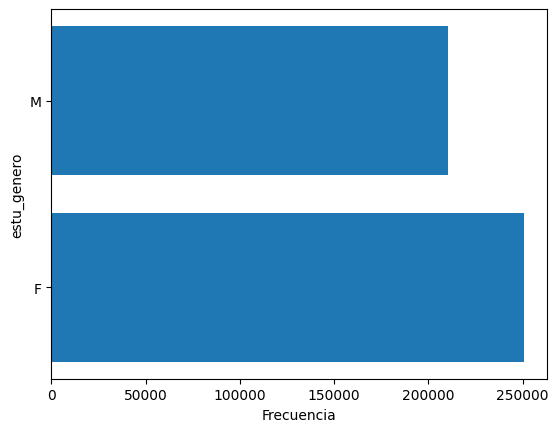

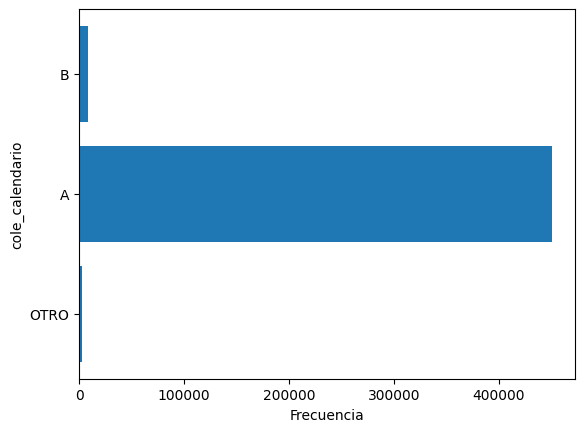

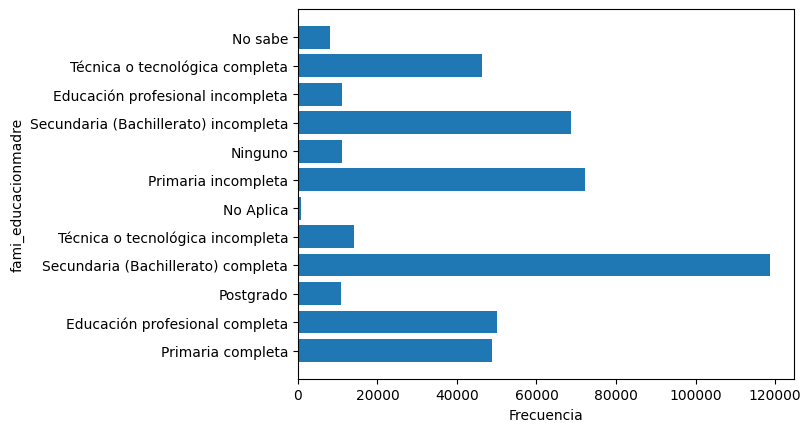

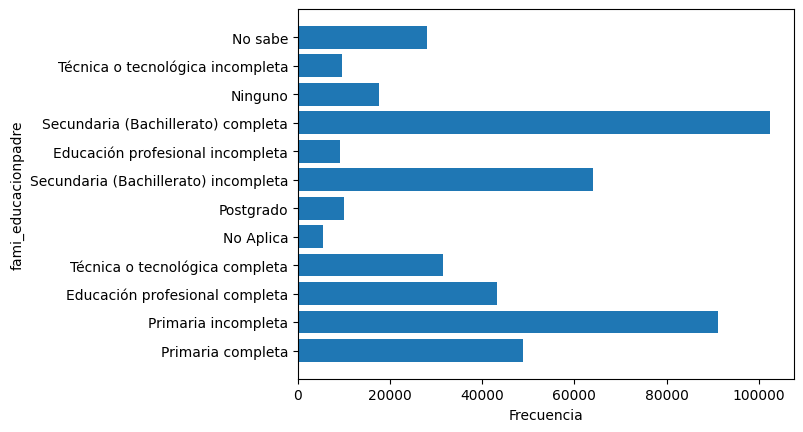

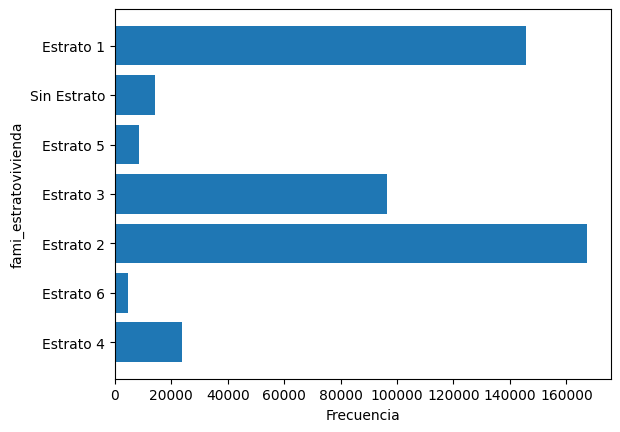

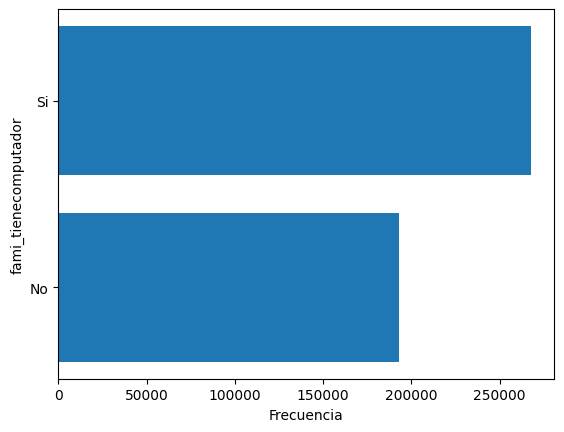

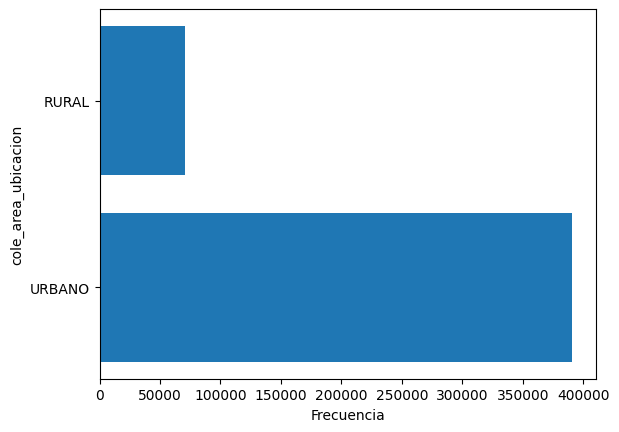

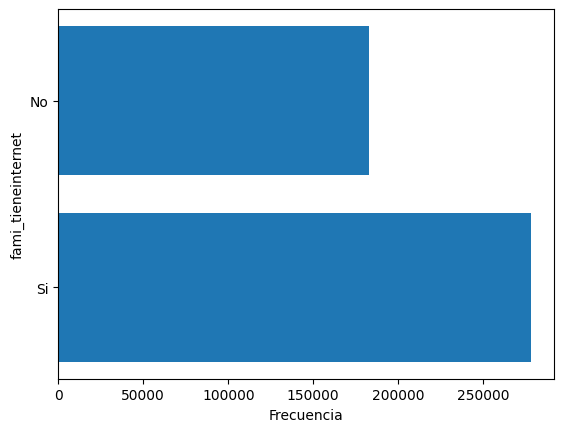

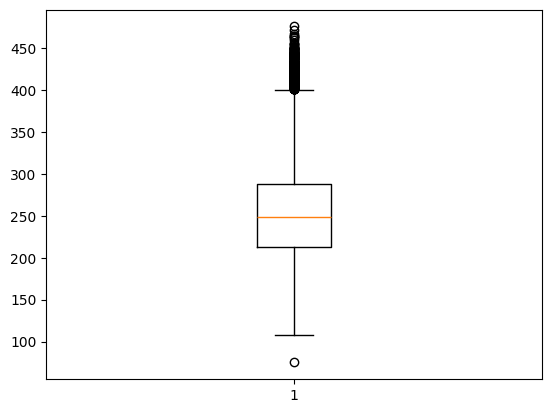

In [19]:
# plot count unique values
var_names_plot = df_h.columns

var_names_plot.remove("punt_global")

for i in var_names_plot:
    count_val = df_h[i].value_counts()

    plt.barh(count_val[i], count_val["count"])
    plt.xlabel("Frecuencia")
    plt.ylabel(i)
    plt.show()

plt.boxplot(df_h["punt_global"])
plt.show()
